<a href="https://colab.research.google.com/github/MJanbandhu/PySpark-MLlib/blob/main/ML_Model_classification_usig_MLLib.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pyspark

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('ml-bank').getOrCreate()
df = spark.read.csv('/content/bank.csv', header = True, inferSchema = True)
df.printSchema()


AnalysisException: [PATH_NOT_FOUND] Path does not exist: file:/content/bank.csv.

In [ ]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().toPandas()

In [ ]:
df = df.select('age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit')
cols = df.columns
df.printSchema()

In [ ]:

1,2,3--4
5,6,7--8
9,10,11--9

[1,2,3]--4
[5,6,7]--8
[9,10,11]--9


In [ ]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'deposit', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [ ]:
stages

In [ ]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)


In [ ]:
df.show(5)

+---+----------+-------+---------+-------+-------+-------+----+-------+--------+--------+-----+--------+--------+-------+--------+--------------+------------+---------------+--------------+-----------------+------------+---------------+------------+---------------+---------+-------------+------------+---------------+-------------+----------------+-----+--------------------+
|age|       job|marital|education|default|balance|housing|loan|contact|duration|campaign|pdays|previous|poutcome|deposit|jobIndex|   jobclassVec|maritalIndex|maritalclassVec|educationIndex|educationclassVec|defaultIndex|defaultclassVec|housingIndex|housingclassVec|loanIndex| loanclassVec|contactIndex|contactclassVec|poutcomeIndex|poutcomeclassVec|label|            features|
+---+----------+-------+---------+-------+-------+-------+----+-------+--------+--------+-----+--------+--------+-------+--------+--------------+------------+---------------+--------------+-----------------+------------+---------------+----------

In [ ]:
selectedCols = ['label', 'features']
df = df.select(selectedCols)

In [ ]:
df.show(2)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  1.0|(30,[3,11,13,16,1...|
|  1.0|(30,[3,11,13,16,1...|
+-----+--------------------+
only showing top 2 rows



In [ ]:
train, test = df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 7855
Test Dataset Count: 3307


In [ ]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

In [ ]:
import matplotlib.pyplot as plt

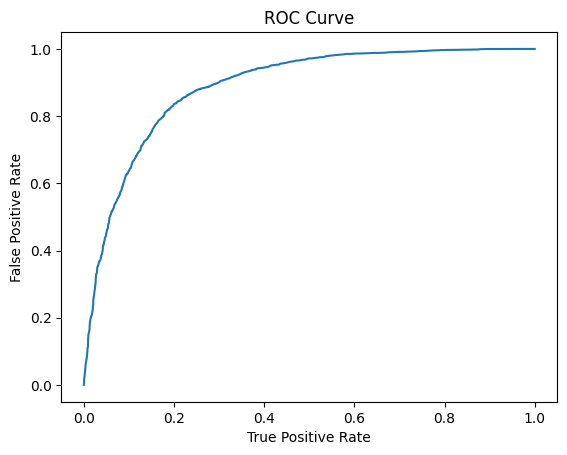

Training set areaUnderROC: 0.8877385690600346


In [ ]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [ ]:
predictions = lrModel.transform(test)
#predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

In [ ]:
predictions.show()

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  0.0|(30,[0,11,13,16,1...|[1.93084854518128...|[0.87334331124860...|       0.0|
|  0.0|(30,[0,11,13,16,1...|[1.92783695472097...|[0.87300981013433...|       0.0|
|  0.0|(30,[0,11,13,16,1...|[-0.7737627890181...|[0.31566570209267...|       1.0|
|  0.0|(30,[0,11,13,16,1...|[0.94708137344074...|[0.72052784002179...|       0.0|
|  0.0|(30,[0,11,13,16,1...|[2.44657764692457...|[0.92031082026376...|       0.0|
|  0.0|(30,[0,11,13,16,1...|[1.28386077546037...|[0.78310624913886...|       0.0|
|  0.0|(30,[0,11,13,16,1...|[1.05745870556531...|[0.74220460119091...|       0.0|
|  0.0|(30,[0,11,13,16,1...|[3.25200815517462...|[0.96274520587479...|       0.0|
|  0.0|(30,[0,11,13,16,1...|[2.24978402804239...|[0.90463190417562...|       0.0|
|  0.0|(30,[0,11

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.885643189559481


In [ ]:
train.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|
|  0.0|(30,[0,11,13,16,1...|
+-----+--------------------+
only showing top 20 rows



In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
predictions.show(20)

+-----+--------------------+--------------+--------------------+----------+
|label|            features| rawPrediction|         probability|prediction|
+-----+--------------------+--------------+--------------------+----------+
|  0.0|(30,[0,11,13,16,1...|[2498.0,481.0]|[0.83853642161799...|       0.0|
|  0.0|(30,[0,11,13,16,1...|[2498.0,481.0]|[0.83853642161799...|       0.0|
|  0.0|(30,[0,11,13,16,1...|[520.0,1931.0]|[0.21215830273357...|       1.0|
|  0.0|(30,[0,11,13,16,1...|[2498.0,481.0]|[0.83853642161799...|       0.0|
|  0.0|(30,[0,11,13,16,1...|[2498.0,481.0]|[0.83853642161799...|       0.0|
|  0.0|(30,[0,11,13,16,1...|[2498.0,481.0]|[0.83853642161799...|       0.0|
|  0.0|(30,[0,11,13,16,1...|[2498.0,481.0]|[0.83853642161799...|       0.0|
|  0.0|(30,[0,11,13,16,1...|[2498.0,481.0]|[0.83853642161799...|       0.0|
|  0.0|(30,[0,11,13,16,1...|[2498.0,481.0]|[0.83853642161799...|       0.0|
|  0.0|(30,[0,11,13,16,1...|[2498.0,481.0]|[0.83853642161799...|       0.0|
|  0.0|(30,[

In [ ]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.7808118726917547


In [ ]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
predictions.show(10)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  0.0|(30,[0,11,13,16,1...|[14.8558655710168...|[0.74279327855084...|       0.0|
|  0.0|(30,[0,11,13,16,1...|[14.7887419298219...|[0.73943709649109...|       0.0|
|  0.0|(30,[0,11,13,16,1...|[7.16536186082170...|[0.35826809304108...|       1.0|
|  0.0|(30,[0,11,13,16,1...|[13.6481420928296...|[0.68240710464148...|       0.0|
|  0.0|(30,[0,11,13,16,1...|[15.2611839025020...|[0.76305919512510...|       0.0|
|  0.0|(30,[0,11,13,16,1...|[14.7376298623880...|[0.73688149311940...|       0.0|
|  0.0|(30,[0,11,13,16,1...|[14.617201930595,...|[0.73086009652975...|       0.0|
|  0.0|(30,[0,11,13,16,1...|[17.2693924216084...|[0.86346962108042...|       0.0|
|  0.0|(30,[0,11,13,16,1...|[16.9100039081227...|[0.84550019540613...|       0.0|
|  0.0|(30,[0,11

In [ ]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8816704814037057


In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator()